In [2]:
import matplotlib.pyplot as plt

In [4]:
% matplotlib inline

import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style("darkgrid")

# Plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import os
import argparse
from ast import literal_eval
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob
from dateutil import parser

import pandas as pd
import numpy as np

from run import create_model
import config
from src.tests import acc_ir, plot_ir

conf = config.get_config()
df = pd.read_csv(conf['database'])

# Only take the once with 200 iterations
# df = df[df.num_steps == 200]

# Parse arrays
df['incumbent'] = df.incumbent.apply(literal_eval)
df['immediate_regret'] = df.immediate_regret.apply(literal_eval)
df.date = df.date.astype('datetime64[ns]')

# Remove invalid seeds (set default seed)
df.loc[df.seed == -1, 'seed'] = 0

# Remove dublicates
df = df.sort_values(by=['date'])
df = df.groupby(["uuid"]).agg(lambda x: x.iloc[0]).reset_index()
df = df.sort_values(by=['date'])

# Make embedding into tuples to support hashing (used in groupby)
df.embedding = df.embedding.fillna('[]')
df.embedding = df.embedding.apply(literal_eval)
df.embedding = [ tuple(row.embedding) for _, row in df.iterrows() ]

# OBS: Global variable used by function!
df_indexed = df.set_index('uuid')

def get_model_conf(uid):
    row = df_indexed.loc[uid]
    model_shortname = row['name']
    model_conf = config.get_model_config(uid, model_shortname, conf)
    return model_conf

def plot_ir_image(model_conf):
    display(Image(filename=model_conf['regret_plot_path']))

def plot_step_image(model_conf):
    # l = os.listdir(model_conf['plot_folder'])
    l_all = glob.glob(os.path.join(model_conf['plot_folder'], '*.png'))
    l_all.sort(key=lambda n: int(n.replace(".", "-").split('-')[-2]))
    l_em = [img for img in l_all if "embedding" in img]
    l = [img for img in l_all if "embedding" not in img]

    def show_image(i):
        if i < len(l):
            display(Image(filename=l[i]))
        if i < len(l_em):
            display(Image(filename=l_em[i]))
    
    length = max(len(l), len(l_em))
    # Only if there are images
    if length > 0:
        interact(show_image, i=widgets.IntSlider(min=0, max=length - 1, step=1, value=0))

def get_XY(model_conf):
    X = np.load(model_conf['obs_X_path'])
    Y = np.load(model_conf['obs_Y_path'])
    return X, Y
    
def recreate_model(uid, model_conf, train=True):
    args = argparse.Namespace(**df_indexed.loc[uid].to_dict())
    args.batch_size = int(args.batch_size) # quick fix
    bo = create_model(args)
    X,Y = get_XY(model_conf)
    bo.model.init(X, Y, train=train)
    return bo

# Delete seedless
df = df.drop(df[(df.date < parser.parse("2018-08-19 15:00")) & (df.date > parser.parse("2018-08-19 13:00"))].index, axis=0)

#df = df[df.date < parser.parse("2018-08-19 15:00")]                                                   # pre weekend (funcs)
df = df[(df.date > parser.parse("2018-08-19 15:00")) & (df.date < parser.parse("2018-08-20 14:15"))]   # weekend (extended) (props)
# df = df[(df.date > parser.parse("2018-08-20 14:15"))]                                                  # post weekend
df

uuid  acq  batch_size                       date  dim_basis  dim_h1  \
260  ce34ca74  UCB        1000 2018-08-19 15:05:45.533826         50      50   
105  5ec68a49  UCB        1000 2018-08-19 15:05:45.621967         50      50   
103  5de2971f  UCB        1000 2018-08-19 15:05:45.672842         50      50   
236  ba9b34db  UCB        1000 2018-08-19 15:06:14.329557         50      50   
37   20cce47c  UCB        1000 2018-08-19 15:06:14.419255         50      50   
280  de64c71d  UCB        1000 2018-08-19 15:06:14.470221         50      50   
85   492453d3  UCB        1000 2018-08-19 15:06:14.516069         50      50   
0    01d99774  UCB        1000 2018-08-19 15:06:14.560171         50      50   
175  8f2742e8  UCB        1000 2018-08-19 15:06:14.567724         50      50   
256  cc5af073  UCB        1000 2018-08-19 15:06:14.586708         50      50   
54   2f15cffc  UCB        1000 2018-08-19 15:06:14.620101         50      50   
326  fc5f078f  UCB        1000 2018-08-19 15:06:14.695595         50      50   
95   51cc3df1  UCB        1000 2018-08-19 15:06:14.703292         50      50   
281  deb334f8  UCB        1000 2018-08-19 15:06:15.179876         50      50   
246  c6665c86  UCB        1000 2018-08-19 15:06:15.181923         50      50   
251  c94622d9  UCB        1000 2018-08-19 15:06:42.662483         50      50   
14   0bca63e6  UCB        1000 2018-08-19 15:06:42.793473         50      50   
279  de23a65f  UCB        1000 2018-08-19 15:06:42.803227         50      50   
310  f26cba0f  UCB        1000 2018-08-19 15:06:42.826870         50      50   
290  e3f67863  UCB        1000 2018-08-19 15:06:42.828779         50      50   
150  7de9db34  UCB        1000 2018-08-20 14:04:53.810731         50      50   
224  af4dd13f  UCB        1000 2018-08-20 14:04:53.810842         50      50   
314  f5cbefce  UCB        1000 2018-08-20 14:04:53.811403         50      50   
289  e34133a7  UCB        1000 2018-08-20 14:04:54.164974         50      50   
250  c8f6e833  UCB        1000 2018-08-20 14:06:23.916865         50      50   
254  cc1ffb7d  UCB        1000 2018-08-20 14:06:23.947706         50      50   
243  c595b30a  UCB        1000 2018-08-20 14:07:23.084209         50      50   
176  903ea0d7  UCB        1000 2018-08-20 14:07:23.101349         50      50   
87   493cf83d  UCB        1000 2018-08-20 14:07:23.388893         50      50   
53   2eef2733  UCB        1000 2018-08-20 14:07:23.477568         50      50   
321  f9f0bbdb  UCB        1000 2018-08-20 14:07:23.479184         50      50   

     dim_h2  epochs  immediate_regret          incumbent  ...    \
260      50     100  [7.42478753e-05]  [-7.42478753e-05]  ...     
105      50    1000  [1.62709662e-06]  [-1.62709662e-06]  ...     
103      50   10000  [9.09344203e-08]  [-9.09344203e-08]  ...     
236      50     100      [0.00040567]      [-0.00224834]  ...     
37       50    1000      [0.05075358]      [-0.09367992]  ...     
280      50    1000      [0.74091854]      [-3.74091854]  ...     
85       50    1000      [4.86429558]      [-7.86429558]  ...     
0        50   10000  [9.53162034e-05]       [3.86268422]  ...     
175      50    1000  [4.81971723e-05]       [3.86273133]  ...     
256      50   10000      [0.00013931]      [-0.00198198]  ...     
54       50    1000      [0.74091854]      [-3.74091854]  ...     
326      50    1000      [0.00221964]      [-0.00406231]  ...     
95       50     100      [0.00025282]       [3.86252671]  ...     
281      50    1000     [29.97841642]      [29.58052906]  ...     
246      50    1000      [0.00072345]      [-0.39861081]  ...     
251      50    1000   [4259.41531385]   [-4259.41531385]  ...     
14       50    1000   [8062.61407548]   [-8062.61407548]  ...     
279      50    1000   [3270.46751991]   [-3270.46751991]  ...     
310      50    1000   [7624.81880872]   [-7624.81880872]  ...     
290      50    1000   [6903.00029335]   [-6903.00029335]  ...     
150      50    1000      [0.13660625]    

In [5]:
import itertools
uuid_keys = ['acq', 'batch_size', 'dim_basis', 'dim_h1', 'dim_h2',
             'epochs', 'lr', 'model', 'n_iter', 'nn_aggregator', 'num_mcmc', 'num_nn',
             'weight_decay', 'obj_func', 'embedding']

def get_regret_history(uids):
    max_hist = []
    for uid in uids:
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=False)
        maxy = np.maximum.accumulate(bo.model.Y)
        
        # Remove output dimension
        maxy = maxy[:,0]

        max_hist.append(maxy)
    # Fills arrays of different length with NaN
    max_hist = np.array(list(itertools.zip_longest(*max_hist, fillvalue=np.nan))).T
    
    mean = np.nanmean(max_hist, axis=0)

    var = np.nanvar(max_hist, axis=0)
    # top = np.maximum(mean + np.sqrt(var), bo.f_opt)
    # bottom = np.maximum(mean - np.sqrt(var), bo.f_opt)
    return np.abs(mean + np.sqrt(var) - bo.f_opt), np.abs(mean - bo.f_opt), np.abs(mean - np.sqrt(var) - bo.f_opt), max_hist

gf = df.groupby(uuid_keys)
df_agg = gf.agg(list).reset_index()
df_agg['regret_history'] = df_agg.uuid.apply(get_regret_history)

reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstraining parameters linear.variances
reconstrain

# Regret Comparer

In [7]:
from src.utils import random_hypercube_samples

def show_ir(obj_func):
    model_rows = df_agg[(df_agg.obj_func == obj_func)]

    # Rand hist
    uid = model_rows.iloc[0].uuid[0]
    model_conf = get_model_conf(uid)
    bo = recreate_model(uid, model_conf, train=False)
    rand_hist = bo.obj_func(random_hypercube_samples(bo.n_init + bo.n_iter, bo.bounds, rng=bo.rng))
    plt.plot(acc_ir(rand_hist, bo.f_opt), label="rand")
    
    for i, row in model_rows.iterrows():
        # mean, var, originals = row['regret_history']
        top, mean, bottom, originals = row['regret_history']
        plt.plot(mean, label=row['name'][0])
        # plt.fill_between(np.arange(mean.shape[0]), mean + np.sqrt(var), mean - np.sqrt(var), alpha=.2)
        plt.fill_between(np.arange(mean.shape[0]), top, bottom, alpha=.2)
        #for orig in originals[:1]:
        #    plt.plot(orig)
        #break
    plt.yscale('log')
    plt.legend()

interact(show_ir, obj_func=df_agg.obj_func.unique())

interactive(children=(Dropdown(description='obj_func', options=('hartmann3', 'levy', 'sintwo', 'rosenbrock10D'…

<function __main__.show_ir(obj_func)>

- Forrester: Note weird rounding error for dngo-nn-5-agg-max leading to increase in otherwise monotone decreasing regret..

In [56]:
# Quick plot
from src.tests import acc_ir, plot_ir

def show_prediction(obj_func):
    model_rows = df_agg[(df_agg.obj_func == obj_func)]
    hist = []
    legends = []
    for i, row in model_rows.iterrows():
        uid = row.uuid[0]
        name = row['name'][0]
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=False)
        print("Model:", name)
        bo.plot_prediction(plot_predictions=False)

interact(show_prediction, obj_func=df_agg.obj_func.unique())

interactive(children=(Dropdown(description='obj_func', options=('hartmann3', 'levy', 'sintwo', 'rosenbrock10D'…

<function __main__.show_prediction(obj_func)>

In [7]:
from src.tests import acc_ir, plot_ir

def show_prediction(obj_func):
    if None:
        return
    model_rows = df_agg[(df_agg.obj_func == obj_func)]
    hist = []
    legends = []
    for i, row in model_rows.iterrows():
        uid = row.uuid[0]
        name = row['name'][0]
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=True)
        print("Model:", name)
        bo.plot_prediction()

interact(show_prediction, obj_func=[None] + list(df_agg.obj_func.unique()))

interactive(children=(Dropdown(description='obj_func', options=(None, 'hartmann3', 'levy', 'sintwo', 'rosenbro…

<function __main__.show_prediction(obj_func)>

# Specific model explorer

In [42]:
def plot(uid):
    model_conf = get_model_conf(uid)
    try:
        plot_step_image(model_conf)
        plot_ir_image(model_conf)
    except Exception as e:
        print(e)
    return uid, model_conf

# multiple selection (num_nn, agg, model, obj_func) -> select from what is left
widget = interactive(plot, uid=list(zip(df.name, df.uuid)))
display(widget)

interactive(children=(Dropdown(description='uid', options=(('ce34ca74--s-1-m-dngo-init-20-k-200-e-100-f-levy',…

In [19]:
uid, model_conf = widget.result
bo = recreate_model(uid, model_conf)

reconstraining parameters linear.variances
 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1


 /Users/tmpethick/GoogleDrive/dtu/8-5-ETH-summer/eth-project/src/models.py:170: RuntimeWarning:invalid value encountered in sqrt
 /Users/tmpethick/GoogleDrive/dtu/8-5-ETH-summer/eth-project/src/acquisition_functions.py:28: RuntimeWarning:invalid value encountered in sqrt


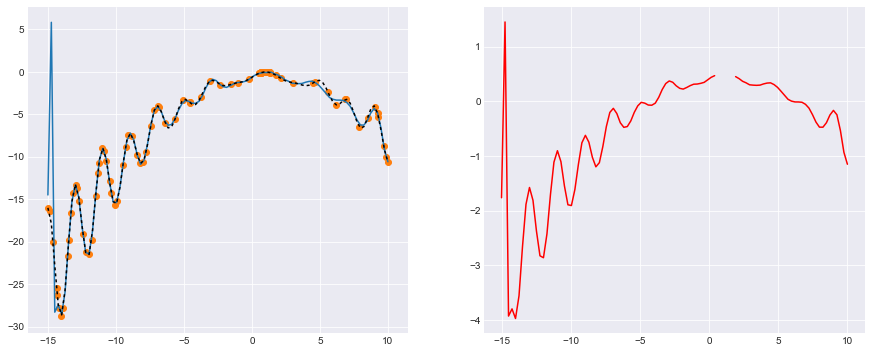

In [20]:
bo.plot_prediction()

In [84]:

fig = bo.plot_2D_surface(use_plotly=True)
iplot(fig)

This is the format of your plot grid:
[ (1,1) scene1 ]  [ (1,2) scene2 ]
[ (2,1) scene3 ]  [ (2,2) scene4 ]



# Logisic Regression Test

In [1]:
%load_ext autoreload
%autoreload 2

from src.logistic_regression_benchmark import LogisticRegression

In [319]:
reg = LogisticRegression()
#reg.run()